Directory already exists: /DeepLearning/mnt/shixiansheng/data_fusion/output/2011_CompareScatter
正在处理文件: /DeepLearning/mnt/shixiansheng/data_fusion/output/2011_Data_WithoutCV/BarronScript_ALL_2011_FtAIndex_CONUS.csv, Period: DJF
x_data 长度: 137241, y_data 长度: 137241
x_data 前5个值: [nan nan nan nan nan]
y_data 前5个值: [29.88703418 29.90692306 29.79395857 29.74799965 29.72631012]
x_data 中 NaN 的数量: 81656
y_data 中 NaN 的数量: 0
RMSE: 3.43, MAE: 2.54


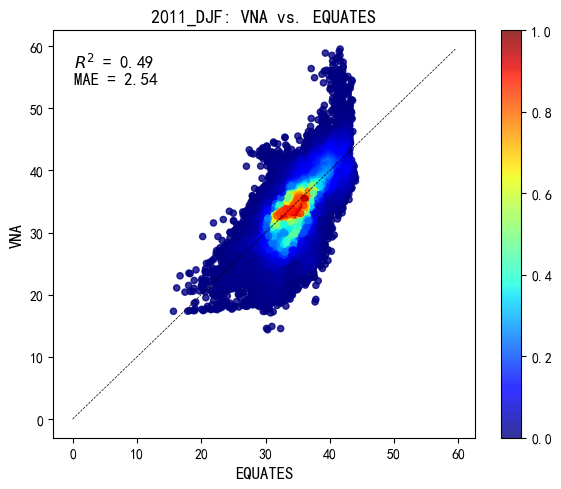

散点密度图已保存至 /DeepLearning/mnt/shixiansheng/data_fusion/output/2011_CompareScatter/BarronScript_ALL_2011_FtAIndex_CONUS_2011_DJF_vna_ozone_vs_model_density.png
正在处理文件: /DeepLearning/mnt/shixiansheng/data_fusion/output/2011_Data_WithoutCV/BarronScript_ALL_2011_FtAIndex_CONUS.csv, Period: DJF
x_data 长度: 137241, y_data 长度: 137241
x_data 前5个值: [nan nan nan nan nan]
y_data 前5个值: [nan nan nan nan nan]
x_data 中 NaN 的数量: 81656
y_data 中 NaN 的数量: 81656


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, linregress
import itertools
import re


# -------------------- 工具函数 --------------------
def extract_key_period(period):
    """
    Extract key period (e.g., JFM, AMJ) from the full period string.
    """
    key_periods = ["DJF", "MAM", "JJA", "SON", 'Annual', 'Apr-Sep', 'top-10', '98th']
    for key in key_periods:
        if key in period:
            return key
    return None


def get_year(filename):
    """
    从文件名中提取年份（假设年份在 2011 - 2020 范围内）。
    """
    match = re.search(r"(20[1-2][0-9])", filename)
    if match:
        return match.group(1)
    return None


def get_axis_label(filename, variable):
    """
    根据文件名和变量生成轴标签。
    - 如果变量为 'model'，根据文件名判断是 'Harvard ML' 还是 'EQUATES'。
    - 其他情况根据变量名确定标签，如 'vna_ozone' 对应 'VNA'。
    """
    if 'model' in variable:
        return "EQUATES"
    elif "harvard_ml" in variable:
        return "Harvard ML"
    elif "vna_ozone" in variable:
        return "VNA"
    elif "evna_ozone" in variable:
        return "eVNA"
    elif "avna_ozone" in variable:
        return "aVNA"
    elif "ds_ozone" in variable:
        return "Downscaler"
    return "unknown"


# -------------------- 定义绘图函数 --------------------
def plot_density_scatter(dataframe_x, dataframe_y, x_column, y_column, period_column, output_dir, period_value, file_name, output_csv_path):
    """
    绘制散点密度图：x_column vs y_column。
    文件名包含对应的 Period 字段。
    """
    # 获取数据（通过关键字匹配 Period）
    df_period_x = dataframe_x[dataframe_x[period_column].str.contains(period_value, case=False, na=False)]
    df_period_y = dataframe_y[dataframe_y[period_column].str.contains(period_value, case=False, na=False)]

    # 如果数据为空，跳过
    if df_period_x.empty or df_period_y.empty:
        print(f"数据中没有有效数据，跳过 Period: {period_value} 的绘图。")
        return

    # 获取数据
    x_data = df_period_x[x_column].values
    y_data = df_period_y[y_column].values

    # 打印正在处理的数据信息
    print(f"正在处理文件: {file_name}, Period: {period_value}")
    print(f"x_data 长度: {len(x_data)}, y_data 长度: {len(y_data)}")
    print(f"x_data 前5个值: {x_data[:5]}")
    print(f"y_data 前5个值: {y_data[:5]}")
    print(f"x_data 中 NaN 的数量: {np.isnan(x_data).sum()}")
    print(f"y_data 中 NaN 的数量: {np.isnan(y_data).sum()}")

    # 核密度计算
    valid_indices = ~np.isnan(x_data) & ~np.isnan(y_data)
    valid_x_data = x_data[valid_indices]
    valid_y_data = y_data[valid_indices]

    if len(valid_x_data) == 0 or len(valid_y_data) == 0:
        print(f"数据为空，跳过 Period: {period_value} 的绘图。")
        return

    # 获取文件名的基名
    file_base_name = os.path.basename(file_name).split(".")[0]

    # 提取年份
    year = get_year(file_name)

    # 只提取季节和年份部分
    period_search = extract_key_period(period_value)
    if period_search:
        period_value = period_search

    # 拼接成期望的格式，如：2011_JAS
    formatted_period = f"{year}_{period_value}"

    # 生成轴标签
    x_label = get_axis_label(x_axis_file, x_column)  # x 轴标签
    y_label = get_axis_label(file_name, y_column)  # y 轴标签

    full_title = f"{formatted_period}: {y_label} vs. {x_label}"

    # 核密度计算
    xy = np.vstack([valid_x_data, valid_y_data])
    kde = gaussian_kde(xy)
    z = kde(xy)
    z = (z - z.min()) / (z.max() - z.min())  # 归一化

    # 绘制散点密度图
    fig, ax = plt.subplots(figsize=(6, 5))
    scatter = ax.scatter(valid_x_data, valid_y_data, c=z, cmap='jet', s=20, alpha=0.8)
    fig.colorbar(scatter, ax=ax)  # 删除了 label 参数

    # 添加 1:1 参考线
    max_val = max(valid_x_data.max(), valid_y_data.max())

    # 调整x和y轴一样并添加余量，如果数据差别不大
    max_val1 = max_val + 3
    ax.set_xlim(-3, max_val1)
    ax.set_ylim(-3, max_val1)

    ax.plot([0, max_val], [0, max_val], 'k--', lw=0.5)

    # 添加回归线
    slope, intercept, r_value, _, _ = linregress(valid_x_data, valid_y_data)
    r_squared = r_value ** 2
    mae = np.mean(np.abs(valid_y_data - valid_x_data))  # 计算 MAE
    rmse = np.sqrt(np.mean((valid_y_data - valid_x_data) ** 2))  # 计算 RMSE
    mb = np.mean(valid_y_data - valid_x_data)  # 计算 MB (平均偏差)

    # 保留两位小数
    r_squared = round(r_squared, 2)
    mae = round(mae, 2)
    rmse = round(rmse, 2)
    mb = round(mb, 2)
    slope = round(slope, 2)

    print(f"RMSE: {rmse}, MAE: {mae}")
    # 将 R2 和 MAE 移到左上角
    ax.text(0.05, 0.95, f"$R^2$ = {r_squared:.2f}\nMAE = {mae:.2f}",
            transform=ax.transAxes, ha="left", va="top", fontsize=12)
    
    # 设置标题和标签
    ax.set_xlabel(x_label, fontsize=12)  # x 轴标签
    ax.set_ylabel(y_label, fontsize=12)  # y 轴标签

    # 将标题放置到图像顶部
    fig.subplots_adjust(top=0.85)  # 调整标题的位置
    ax.set_title(full_title, fontsize=13, loc='center')

    # 保存图像，文件名包含 Period 字段和输入文件名（不含路径）
    output_file_name = f'{file_base_name}_{formatted_period}_{y_column}_vs_{x_column}_density.png'
    output_path = os.path.join(output_dir, output_file_name)
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.show()
    print(f"散点密度图已保存至 {output_path}")

    # 将计算结果添加到表格中
    variable_pair = f"{y_label} vs. {x_label}"
    result_dict = {
        'Variable Pair': variable_pair,
        'Period': formatted_period,
        'Slope': slope,
        'R_squared': r_squared,
        'RMSE': rmse,
        'MB': mb
    }
    result_df = pd.DataFrame([result_dict])
    if not os.path.exists(output_csv_path):
        result_df.to_csv(output_csv_path, index=False)
    else:
        result_df.to_csv(output_csv_path, mode='a', header=False, index=False)


# -------------------- 读取和处理多个文件 --------------------
def process_file(fusion_output_file, x_axis_file):
    # 读取第一个文件的数据（y 轴数据）
    df_data_y = pd.read_csv(fusion_output_file)

    # 读取第二个文件的数据（x 轴数据）
    df_data_x = pd.read_csv(x_axis_file)

    # 提取Period列
    period_column = 'Period'  # Period列

    variables = ['model', 'vna_ozone', 'evna_ozone', 'avna_ozone', 'ds_ozone', 'harvard_ml']
    comparisons = list(itertools.combinations(variables, 2))

    # 定义需要匹配的关键字（如 JFM, AMJ, JAS, OND 等）
    keywords = ["DJF", "MAM", "JJA", "SON", 'Annual', 'Apr-Sep', 'top-10']

    # 提取年份
    year_x = get_year(x_axis_file)
    year_y = get_year(fusion_output_file)

    if year_x != year_y:
        print("Warning: The years in the input files do not match!")
        return

    year = year_x

    # 动态生成路径名称
    output_dir = os.path.join('/DeepLearning/mnt/shixiansheng/data_fusion/output', f"{year}_CompareScatter")

    # 如果路径不存在，则自动创建
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created directory: {output_dir}")
    else:
        print(f"Directory already exists: {output_dir}")

    output_csv_path = os.path.join(output_dir, '2011_MethodCompareTable.csv')

    # 遍历每个关键字并绘制图形
    for keyword in keywords:
        for x_column, y_column in comparisons:
            plot_density_scatter(df_data_x, df_data_y, x_column, y_column, period_column, output_dir, keyword,
                                 fusion_output_file, output_csv_path)


if __name__ == "__main__":
    # 输入文件
    fusion_output_files = [
        "/DeepLearning/mnt/shixiansheng/data_fusion/output/2011_Data_WithoutCV/BarronScript_ALL_2011_FtAIndex_CONUS.csv",
    ]
    x_axis_file = "/DeepLearning/mnt/shixiansheng/data_fusion/output/2011_Data_WithoutCV/BarronScript_ALL_2011_FtAIndex_CONUS.csv"

    for file in fusion_output_files:
        process_file(file, x_axis_file)
    